### Machine Learning Technique 3 - Clustering

# 1. Group Newsgroup Posts by Topic

This notebook will demonstrate how to use basic scikit functionalities to cluster objects.

The goal is to load many posts from a news group, that are about different topics, and to discover clusters of documents that are similar. We will get the topics, but will not use them in the algorithm, because this method is unsupervised and we will see how "magic" such an approach is.

#### Data:

This time, the dataset is a toy dataset that is **available in the scikit library**. Hence, you do not need to download anything yourself. You do, however, require an **Internet connection** in order to let sklearn download it for you.

#### Links:

- [Clustering Scikit Demo](http://scikit-learn.org/stable/auto_examples/text/document_clustering.html)
- [Newsgroup Documentation 1](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html#newsgroups)
- [Newsgroup Documentation 2](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups)

# 2. Import Libraries

In [2]:
# Starting by importing our beloved libraries: pandas, numpy, matplotlib.pyplot
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# 3. Load the Data

We are using the `fetch_20newsgroups` available in the scikit-learn examples for this notebook. We just need to import the function and call it. We will load a training set and a test set.

**Initial Dataset:**

The `fetch_20newsgroups` contains a total of 18846 entries and has 20 different categories. Those categories are:

- alt.atheism
- comp.graphics
- comp.os.ms-windows.misc
- comp.sys.ibm.pc.hardware
- comp.sys.mac.hardware
- comp.windows.x
- misc.forsale
- rec.autos
- rec.motorcycles
- rec.sport.baseball
- rec.sport.hockey
- sci.crypt
- sci.electronics
- sci.med
- sci.space
- soc.religion.christian
- talk.politics.guns
- talk.politics.mideast
- talk.politics.misc
- talk.religion.misc

We are going to only select a few of those and, as such, reduce the size of the dataset, because it will be easier to plot the data later. :)

**Training dataset:**

For the training data, `fetch_20newsgroups` allows us to request it directly and it allows us to remove unneeded parts of the posts. Here, we will remove the headers, footers and quotes.

**Test dataset:**

For the test data, `fetch_20newsgroups` also allows us to request it directyl. However, here we will leave all parts in. We will see later how it looks like.

In [3]:
# Import the sklearn example function
from sklearn.datasets import fetch_20newsgroups

# Define our subset of categories
categories = ['sci.space', 'comp.windows.x', 'rec.sport.baseball', 'soc.religion.christian']

# Request the training data
newsgroup_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=categories)

# Request the test data
newsgroup_test = fetch_20newsgroups(subset='test', categories=categories)

# 4. Explore a little

In [ ]:
newsgroup_train

In [5]:
# Looks like a dictionary, so let's print the keys
newsgroup_train.keys()

dict_keys(['target_names', 'description', 'data', 'DESCR', 'filenames', 'target'])

In [6]:
# Train: Print the size of different attributes
print('- Train:')
print('{:10} documents'.format( len(newsgroup_train.data) ))
print('{:10} targets'.format( len(newsgroup_train.target) )) # Should be same as #documents
print('{:10} categories'.format( len(newsgroup_train.target_names) ))

# Test: Print the size of different attributes
print('\n- Test:')
print('{:10} documents'.format( len(newsgroup_test.data) ))
print('{:10} targets'.format( len(newsgroup_test.target) )) # Should be same as #documents
print('{:10} categories'.format( len(newsgroup_test.target_names) ))

- Train:
      2382 documents
      2382 targets
         4 categories

- Test:
      1584 documents
      1584 targets
         4 categories


In [7]:
# Show categories (This should be the same as we defined)
target_names = newsgroup_train['target_names']

target_names

['comp.windows.x', 'rec.sport.baseball', 'sci.space', 'soc.religion.christian']

# 5. Slice / Split the data into training and validation

Since, in this example we had a helper function that already gave to us the training and test data, we do not need to split it again. We are ready for the next steps.

As reminder, if you had to split, you could use the `train_test_split` function like the following example:

    from sklearn.cross_validation import train_test_split
    train, test = train_test_split(dataset, test_size=0.3)

# 6. Pre-Processing Text Data - Feature Extraction

Let's start with pre-processing the data. We are going to focus on 2 aspects:

1. Convert the data into a DataFrame. The current data is in a dictionary where the value are lists. We prefer DataFrame, because it is easier to work with big data.
2. Process the text and extract features from the text.

## 6.1 Data to DataFrame

In [8]:
# The target are the labelled clusters of the dataset
# We are lucky to have them, but won't use them much.
newsgroup_train.target

array([0, 0, 2, ..., 2, 2, 0])

In [9]:
# First save the targets for later
train_target = newsgroup_train.target
test_target = newsgroup_test.target

# Just convert the train data to a dataframe
newsgroup_train = pd.DataFrame(newsgroup_train.data, columns=['text'])
newsgroup_test = pd.DataFrame(newsgroup_test.data, columns=['text'])

In [10]:
# First 10 posts of training
newsgroup_train.head(10)

,text
0,I am in the process of modifying an X applicat...
1,"How can get a pixel value from a Drawable, wit..."
2,According to a Software engineering professor ...
3,\n\nThe gravity data is collected in real-time...
4,\tDoug> NNTP-Posting-Host: se05.wg2.waii.com\n...
5,"First game, first at bat."
6,"\n\n\nActually, that is no longer true. In the..."
7,\n\n\nAre we talking about an xterm which woul...
8,\n\n\nThey have a few problems. The biggest te...
9,"\n\n\n\nWell, I think that most Christians bel..."


In [11]:
# First 10 posts of testing
newsgroup_test.head(10)

,text
0,From: henry@zoo.toronto.edu (Henry Spencer)\nS...
1,From: nabil@cae.wisc.edu (Nabil Ayoub)\nSubjec...
2,From: kjenks@gothamcity.jsc.nasa.gov\nSubject:...
3,"From: ""Dennis G Parslow"" <p00421@psilink.com>\..."
4,From: wyllie@helios.physics.utoronto.ca (Andre...
5,From: prb@access.digex.net (Pat)\nSubject: Re:...
6,From: palmer@cco.caltech.edu (David M. Palmer)...
7,From: aws@iti.org (Allen W. Sherzer)\nSubject:...
8,From: tedward@cs.cornell.edu (Edward [Ted] Fis...
9,From: dawagner@phoenix.Princeton.EDU (David A....


In [12]:
# Show the first message
newsgroup_train['text'][0]

"I am in the process of modifying an X application that uses Xlib.  I'd\nlike to include a timer-driven facility (for network polling), but cannot\nsee how to do it using Xlib.  I know it can be done with Xaw, using\nXtAppAddTimeout and XtTimerCallBackProc.  How do I do the same using\nXlib?\n\nThanks for any help.  Please email.\n"

In [13]:
# Let's make use of the random module to just browse through some of the rows
import random

random_index = random.randrange(len(newsgroup_train))

newsgroup_train['text'][ random_index ]

'\nCan anybody name a player who was \'rushed\' to the majors (let\'s, for\nargument\'s sake, define "rushed" as brought up to the majors for more than\na cup of coffee prior at age 22 or younger, and performing below\nexpectations), whose career was damaged by this rushing?  I\'m serious; I\ntend to agree with David that bringing the player up sooner is better, but\nI\'d like to look at players for whom this theory didn\'t work, if there are\nany.  I\'d prefer players within the last 10 years or so, because then I can\nlook up their minor league stats.  (It\'s important to distinguish between\nplayers who legitimately had careers below what their minor league numbers\nwould have projected, as opposed to players who were hyped and failed, but\nactually had careers not out of line with their minor league numbers).  \n\nLet\'s kick it off with an example of a player who was "rushed", although\nthere doesn\'t seem to have been any damage to his career.  Jay Bell was\ngiven 135 PAs in the 

In [14]:
random_index = random.randrange(len(newsgroup_test))
newsgroup_test['text'][ random_index ]

'From: C Robert Claydon <cclaydon@magnus.acs.ohio-state.edu>\nSubject: CUB fever.\nOrganization: The Ohio State University\nX-Mailer: ELM [version 2.3 PL11]\nLines: 13\n\nkingoz@camelot.bradley.edu (Orin Roth) writes:\n>   CUB fever is hitting me again. I\'m beginning to think they have a\n>   chance this year. (what the heck am i thinking?)\n>   Sorry. Just a moment of incompetence.\n>   I\'ll be ok. Really.\n>   Orin.\n>   Bradley U.\n\nYou sure?  This maybe a chronic syndrome.  If it persists, we may have to \nbanish you to the "Cub-crazy Sanatarium" in north Chicago...\n:-):-):-)\n\nRob\n'

This is cleaner.

**There are a few things to note:**

- The training data has been imported via a function that removed headers, footers and quotes from the original message. We chose to not spend too much time on advanded techniques to clean text data, because it is better to focus on the core, which is tokenizing and extracting features.
- The test data is original and has not been pre-processed or cleaned.

## 6.2 Feature Extraction using TF-IDF

To train any kind of machine learning model using text data, we need to, somehow, transform the text into another format that allows an algorithm to do computations.

One way to extract features would be to take all words and then count them. Counting is really basic, and not really good for machine learning, because words like 'a', 'an', 'the', 'for', ... appear naturally a lot in an english text.

This is why we remove stopwords from the list of extracted words. 

Still, this is not making things good, because there are words that are not important, or less meaningful, but appear a lot, and words that are very important, or very meaningful, but unfortunatly appear only a few times. 

Using a count technique, we basically make the most frequent word win!

**TF-IDF:**

TF-IDF stands for *term frequency inverse document frequency*.

I will not go too deep into the details. Check the links below to get more explanations and details about the method.
The basic things to know is:

- You take the frequency of each words in each document (term frequency)
- You take, for each word, the number of documents containing that word (document frequency)

The document frequency is high for words that appear a lot (common/boring words) and low for words that are rare.
So, dividing the term frequency by the document frequency we get a low score for boring words and a high score for rare words.

**Links:**

- [TF-IDF Simple Explanation](http://planspace.org/20150524-tfidf_is_about_what_matters/)

- [sklearn documentation of TF-IDF](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)
- [TF-IDF Explanation 1](http://www.tfidf.com)
- [TF-IDF Explanation Wikipedia](https://en.wikipedia.org/wiki/Tf–idf)

In [15]:
import re
import nltk
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [18]:
# Import TF-IDF from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

# We can give stopwords as parameters already
# We can try later what happens if we don't remove stopwords
stopwords_english = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn']

# Initialize the TF-IDF object.
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, 
                                   min_df=2, 
                                   max_features=10000, 
                                   stop_words=stopwords_english, 
                                   tokenizer=tokenize_and_stem)

# Extract features from the text data
%time tfidf_matrix = tfidf_vectorizer.fit_transform( newsgroup_train['text'] )

# Print the shape
print(tfidf_matrix.shape)

CPU times: user 12.7 s, sys: 43.6 ms, total: 12.8 s
Wall time: 12.8 s
(2382, 10000)


# 7. Creating, Training & Measuring the Model

The next step is to create and train our model and see how we can create our first clusters.

The algorithm we are going to is called **K-Means** and it is an unsupervised clustering algorithm. 
It can take as an input the TF-IDF matrix and also needs an **initial number of clusters**.

To understand a bit how the algorithm works, those are the basic steps that it performs:

1. Randomly choose k items and define them as initial centroids (= center of cluster). 
2. For each point, find the nearest centroid and assign the point to the cluster associated with the nearest centroid. 
3. Update the centroid of each cluster based on the items in that cluster. Typically, the new centroid will be the average of all points in the cluster. 
4. Repeats steps 2 and 3, till no point switches clusters.

**Performance:**



**Links:**

- [KMeans Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans)
- [KMeans Explanation 1](http://bigdata-madesimple.com/possibly-the-simplest-way-to-explain-k-means-algorithm/)
- [KMeans Explanation 2 - with animation](https://codeahoy.com/2017/02/19/cluster-analysis-using-k-means-explained/)
- [KMeans Explanation 3 - YouTube](https://www.youtube.com/watch?v=RD0nNK51Fp8)

## 7.1 Create and Train the Model

*The next cell might take a few minutes*

In [19]:
# Import KMeans
from sklearn.cluster import KMeans

def create_cluster(data, n_clusters, max_iter=300, n_init=10):
    print('Creating KMeans Model:')
    print('  #Clusters      : {:5}'.format(n_clusters))
    print('  Max Iterations : {:5}'.format(max_iter))
    print('  #Initalisatons : {:5}'.format(n_init))
    
    print('\nIn Progress...\n')
    
    # Create the model
    km = KMeans(n_clusters=n_clusters, 
                max_iter=max_iter, 
                n_init=n_init) # , init='k-means++', max_iter=100, n_init=1

    # Train the model ("%time" computes the execution time in Jupyter notebooks)
    %time km.fit(data)

    print('\nDone!')
    
    return km

In [20]:
# Define the number of clusters
# We fetched 4 categories, so we are going to use 4 clusters
n_clusters = len(categories)

model = create_cluster(tfidf_matrix, n_clusters)

# Get the computed clusters for each document / row
clusters = model.labels_.tolist()

Creating KMeans Model:
  #Clusters      :     4
  Max Iterations :   300
  #Initalisatons :    10

In Progress...

CPU times: user 19.7 s, sys: 216 ms, total: 19.9 s
Wall time: 7.76 s

Done!


## 7.2 Check the Clusters

In [21]:
# We can check the clusters for the first 10 documents
clusters[:10]

[2, 2, 1, 1, 1, 0, 1, 1, 1, 3]

In [22]:
# Add it to the dataframe
newsgroup_train['cluster'] = clusters

newsgroup_train.head(25)

,text,cluster
0,I am in the process of modifying an X applicat...,2
1,"How can get a pixel value from a Drawable, wit...",2
2,According to a Software engineering professor ...,1
3,\n\nThe gravity data is collected in real-time...,1
4,\tDoug> NNTP-Posting-Host: se05.wg2.waii.com\n...,1
5,"First game, first at bat.",0
6,"\n\n\nActually, that is no longer true. In the...",1
7,\n\n\nAre we talking about an xterm which woul...,1
8,\n\n\nThey have a few problems. The biggest te...,1
9,"\n\n\n\nWell, I think that most Christians bel...",3


In [23]:
# We can count the values:
newsgroup_train['cluster'].value_counts()

1    1218
3     409
2     407
0     348
Name: cluster, dtype: int64

In [58]:
def print_clusters(model, tfidf, n_clusters):
    # Get the cluster centers
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    
    # Get all the terms
    terms = tfidf.get_feature_names()

    # For each cluster, print the top 50 words
    for i in range( n_clusters ):

        print('*** Cluster {:3}:'.format(i))

        top10 = order_centroids[i, :50]
        
        print( ', '.join( [terms[ind] for ind in top10 ] ) )
        print()

In [59]:
print_clusters(model, tfidf_vectorizer, n_clusters)

*** Cluster   0:
game, 's, year, team, n't, pitch, player, hit, run, win, last, score, play, good, think, basebal, brave, fan, season, leagu, would, get, bat, first, one, like, go, better, defens, pitcher, ball, hitter, alomar, offens, well, much, home, start, averag, time, red, back, look, still, onli, stat, yanke, doe, becaus, lot

*** Cluster   1:
space, 's, n't, would, one, like, thank, know, ani, use, anyon, get, pleas, could, orbit, think, launch, doe, 'm, go, post, time, also, nasa, peopl, onli, thing, work, much, year, need, list, someth, veri, look, program, system, moon, us, day, problem, make, read, see, interest, book, whi, may, well, someon

*** Cluster   2:
window, x, use, server, widget, applic, program, ani, run, display, file, motif, get, thank, problem, client, doe, code, 's, work, appreci, n't, tri, like, color, set, version, would, manag, look, help, support, know, system, xterm, call, colormap, anyon, one, want, event, 'm, function, find, user, x11r5, creat, error,

In [88]:
from sklearn.decomposition import PCA

def plot_cluster(matrix, model):
    ''' Plot the cluster in 2D. 
    '''
    X = matrix.todense()

    pca = PCA(n_components=2).fit(X)
    data2D = pca.transform(X)
    
    plt.figure(figsize=(20,20))
    plt.scatter(data2D[:,0], 
                data2D[:,1], 
                c=model.labels_, 
                label="Documents")
    plt.legend()

    centers2D = pca.transform(model.cluster_centers_)

    plt.hold(True)
    plt.scatter(centers2D[:,0], 
                centers2D[:,1], 
                marker='x', 
                s=200, 
                linewidths=3, 
                c='r',
                label="Cluster Centers")
    
    plt.legend()

    plt.show()

/Users/ralphmarschall/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/Users/ralphmarschall/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/ralphmarschall/anaconda/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


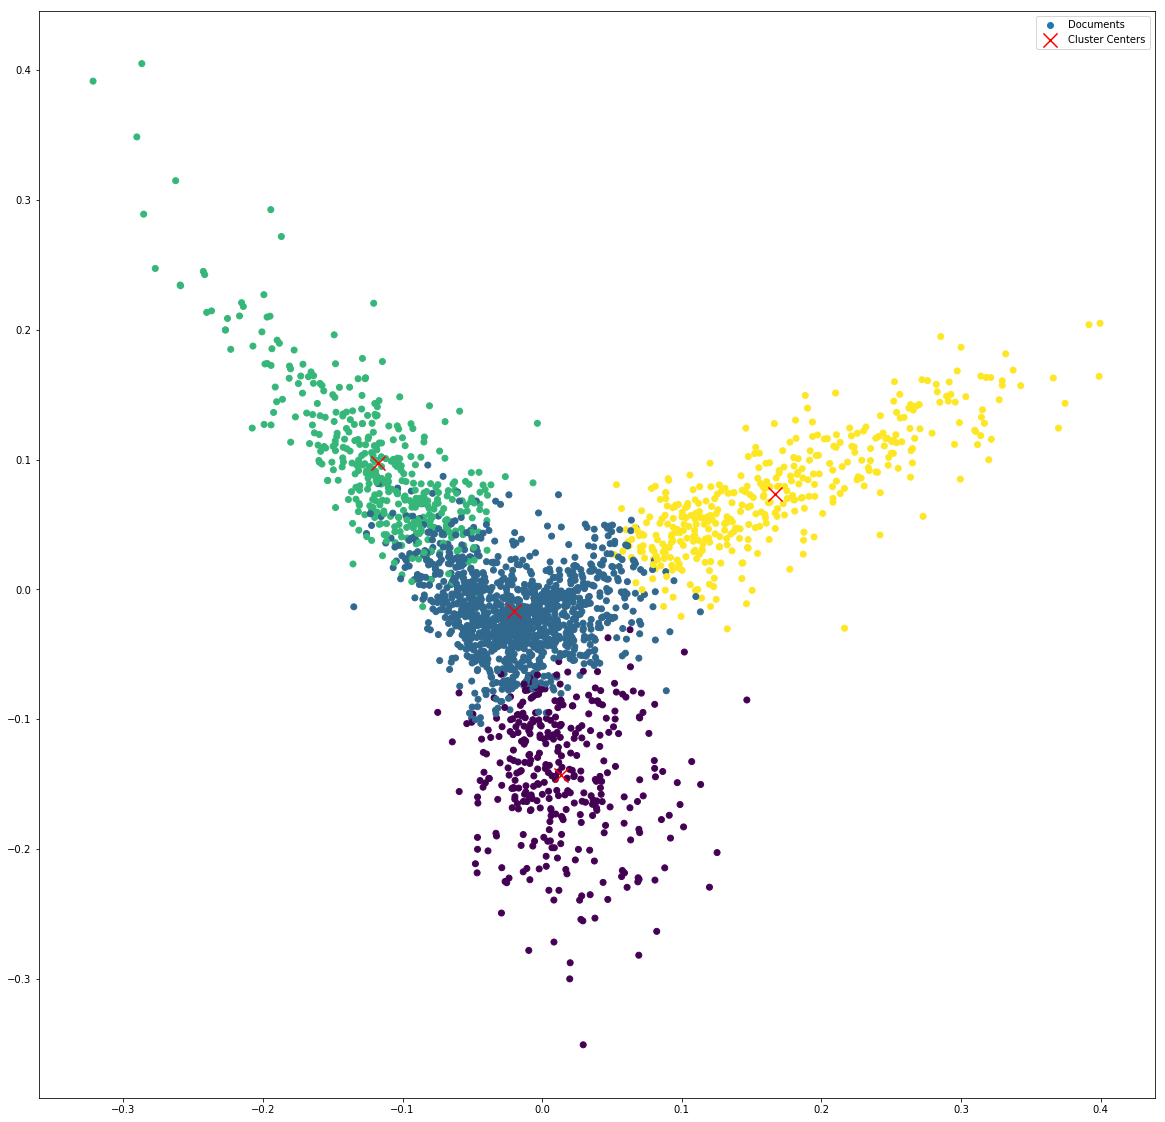

In [89]:
plot_cluster(tfidf_matrix, model)

# 8. Model Evaluation

Let's finish by evaluating our model. We know we need to find some quality metrics in order to have a basis to improve.

The challenge here is that evaluating clustering results is much harder than computing the accuracy of a supervised algorithm.

So, for this lesson, we are not going to go into the details of this part, because it is more complex than what we plan to cover here. However, the scikit-learn website contains many explanation for those who are most interested in. Check the links below:

**Links:**

- [Documentation - Clustering Evaluation](http://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation)
- [Documentation - Clustering Metrics](http://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)

In [64]:
from sklearn import metrics

labels = train_target

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, model.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, model.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, model.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, model.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(tfidf_matrix, model.labels_, sample_size=1000))


Homogeneity: 0.509
Completeness: 0.574
V-measure: 0.540
Adjusted Rand-Index: 0.361
Silhouette Coefficient: 0.010


In [65]:
# Extract features from the text data
test_tfidf = tfidf_vectorizer.transform( newsgroup_test['text'] )

%time model.predict( test_tfidf )

array([1, 3, 1, ..., 1, 1, 1], dtype=int32)

In [66]:
newsgroup_test['text'][0]

'From: henry@zoo.toronto.edu (Henry Spencer)\nSubject: Re: Long Term Space Voyanges and Effect NEwsgroup?\nOrganization: U of Toronto Zoology\nLines: 11\n\nIn article <1993Apr26.222659.1@aurora.alaska.edu> nsmca@aurora.alaska.edu writes:\n>I vote for a later on sci.space.medicine or similar newsgroup fro the\n>discussion of long term missions into space and there affects on humans and\n>such..\n\nWhy bother with a new newsgroup?  If you want to discuss the subject,\n*start discussing it*.  If there is enough traffic to annoy the rest of\nus, we will let you know... and *then* it will be time for a new newsgroup.\n-- \nSVR4 resembles a high-speed collision   | Henry Spencer @ U of Toronto Zoology\nbetween SVR3 and SunOS.    - Dick Dunn  |  henry@zoo.toronto.edu  utzoo!henry\n'

In [67]:
newsgroup_test['text'][1]

"From: nabil@cae.wisc.edu (Nabil Ayoub)\nSubject: Re: Monophysites and Mike Walker\nOrganization: U of Wisconsin-Madison College of Engineering\nLines: 83\n\nIn article <May.10.05.08.01.1993.3602@athos.rutgers.edu> db7n+@andrew.cmu.edu (D. Andrew Byler) writes:\n>Nabil Ayoub writes:\n>\n>>As a final note, the Oriental Orthodox and Eastren Orthodox did sign a\n>>common statement of Christology, in which the heresey of >Monophysitism\n>>was condemned. So the Coptic Orthodox Church does not believe in\n>>Monophysitism.\n>\n>Sorry!\n>\n>What does the Coptic Church believe about the will and energy of Christ?\n> Were there one or were there two (i.e. Human and Divine) wills and\n>energies in Him.\n>\n>Also, what is the objection ot the Copts with the Pope of Rome (i.e. why\n>is there a Coptic Catholic Church)?  Do you reject the supreme\n>jurisdiction of the 263rd sucessor of St. Peter (who blessed St. John\n>Mark, Bishop of Alexandria was translator for) and his predecessors?  Or\n>his inf

In [34]:
newsgroup_test['text'][2]

'From: kjenks@gothamcity.jsc.nasa.gov\nSubject: U.S. Government and Technolgy Investment\nOrganization: NASA/JSC/GM2, Space Shuttle Program Office \nX-Newsreader: TIN [version 1.1 PL8]\nLines: 44\n\nPeople who criticize "big Government" and its projects rarely seem to\nhave a consistent view of the role of Government in science and\ntechnology.  Basically, the U.S. Government has gotten into the role of\nsupporting research which private industry finds too expensive or too\nlong-term.  \n\n(Historically, this role for the U.S. Gov\'t was forced upon it because\nof socialism in other countries.  In order for U.S.  industries to\ncompete with government-subsidized foreign competitors, the U.S. Gov\'t\nhas taken on the role of subisizing big-ticket or long-lead R&D.)\n\nAs a Republican, I abhor the necessity for our Government to involve\nitself in technology this way.  I believe that market forces should\ndrive technology, and the world would be a better place for it.  But\nthe whole wor

# Trying different models and different data

Overview of categories:

- alt.atheism
- comp.graphics
- comp.os.ms-windows.misc
- comp.sys.ibm.pc.hardware
- comp.sys.mac.hardware
- comp.windows.x
- misc.forsale
- rec.autos
- rec.motorcycles
- rec.sport.baseball
- rec.sport.hockey
- sci.crypt
- sci.electronics
- sci.med
- sci.space
- soc.religion.christian
- talk.politics.guns
- talk.politics.mideast
- talk.politics.misc
- talk.religion.misc



In [ ]:
categories = ['sci.space', 'comp.windows.x', 'rec.sport.baseball', 'soc.religion.christian']

# Request the training data
data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), categories=categories)

In [41]:
# Initialize the TF-IDF object.
vectorizer = TfidfVectorizer(max_df=0.5, 
                             min_df=2, 
                             max_features=10000, 
                             stop_words=stopwords_english) 
#                             tokenizer=tokenize_and_stem)

# Extract features from the text data
tfidf = vectorizer.fit_transform( data['text'] )

In [42]:
# Define the number of clusters
# We fetched 4 categories, so we are going to use 4 clusters
n_clusters = len(categories)

model_2 = create_cluster(tfidf, n_clusters)

# Get the computed clusters for each document / row
clusters = model_2.labels_.tolist()

Creating KMeans Model:
  #Clusters      :     4
  Max Iterations :   300
  #Initalisatons :    10

In Progress...

CPU times: user 32.1 s, sys: 251 ms, total: 32.4 s
Wall time: 12.1 s

Done!


In [46]:
print_clusters(model_2, vectorizer, n_clusters)

*** Cluster   0:
space, would, one, like, think, nasa, know, people, could, also, anyone, time, get, much, launch, moon, us, orbit, earth, well, might, something, may, see, good, shuttle, edu, first, use, new, go, make, data, long, even, say, idea, lunar, things, going, really, want, jewish, heard, way, book, need, actually, program, someone

*** Cluster   1:
year, team, game, games, runs, baseball, hit, last, pitching, good, players, braves, think, win, season, first, one, would, like, better, league, home, alomar, well, player, ball, time, years, much, sox, play, run, back, teams, fan, still, get, fans, average, two, hitter, know, got, day, could, best, go, bad, also, see

*** Cluster   2:
window, thanks, server, motif, please, get, use, widget, windows, application, anyone, using, hi, know, would, file, program, display, x11r5, like, xterm, running, code, problem, list, advance, mail, help, one, could, sun, mit, color, set, information, find, version, work, appreciate, manager, want

/Users/ralphmarschall/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Users/ralphmarschall/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/Users/ralphmarschall/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/ralphmarschall/anaconda/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


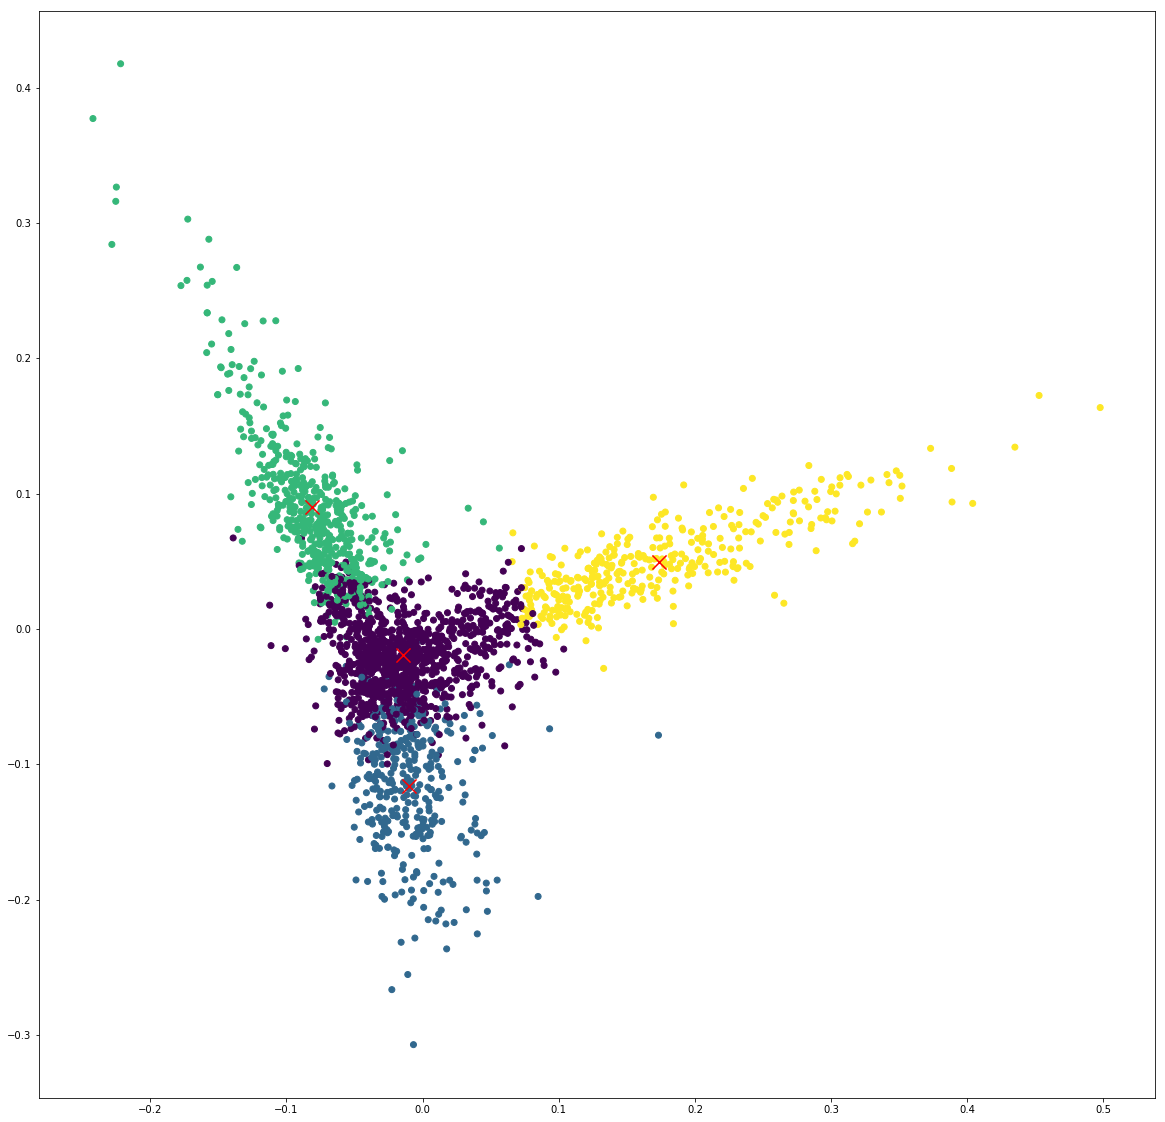

In [44]:
plot_cluster(tfidf, model_2)